<a href="https://colab.research.google.com/github/AnabelleSouza/CRUD_PDO-CONTEINER/blob/main/wine_%7C_Exercicio_2_ID%3D186.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exercício 2


In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [4]:
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pymc as pm
import numpy as np
import arviz as az

In [5]:
# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separar dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az


def analise_priori(trace, y):
    fig, axes = plt.subplots(3, 2, figsize=(10, 10), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

    # Acessar os valores dos betas a partir do grupo 'prior'
    betas_values = trace.prior['betas'].values.flatten()  # Acessa os betas do grupo 'prior' e achata
    sns.histplot(betas_values, bins=20, kde=True, ax=axes[0][0])
    axes[0][0].set_xlabel("Betas")
    axes[0][0].set_ylabel("Contagem")

    # Histograma para as previsões da variável dependente (priors)
    y_obs_values = trace.prior_predictive['Y_obs'].values.flatten()  # Acessa as previsões a priori de Y_obs
    sns.histplot(y_obs_values, bins=20, kde=True, ax=axes[0][1])
    axes[0][1].set_xlabel("Previsões a Priori (Y_obs)")
    axes[0][1].set_ylabel("Contagem")

    # Previsões a priori
    prior_samples = trace.prior_predictive['Y_obs'].values  # Acessa os valores de Y_obs a partir da distribuição preditiva
    prior_samples_reshaped = prior_samples.reshape(len(y), -1)

    # Cálculo da média e desvio padrão das previsões a priori
    mean_pred = np.mean(prior_samples_reshaped, axis=1)
    std_pred = np.std(prior_samples_reshaped, axis=1)

    # Plotar as previsões médias a priori
    sns.lineplot(x=range(len(y)), y=mean_pred, ax=axes[1][0])
    axes[1][0].fill_between(range(len(y)), mean_pred - std_pred, mean_pred + std_pred, alpha=0.2)

    axes[1][0].set_title("Previsões a Priori")
    axes[1][0].set_xlabel("Observado")
    axes[1][0].set_ylabel("Previsões")
    axes[1][0].legend(['Previsões Médias'])

    # Gráficos cumulativos da priori usando Arviz
    az.plot_ppc(trace, group='prior', kind='cumulative', ax=axes[2][0], observed=True)
    az.plot_ppc(trace, group='prior', ax=axes[2][1], observed=True)

    plt.tight_layout()
    return fig, axes

RIDGE

In [7]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Certificar que y tenha a forma correta
y = y.to_numpy().reshape(-1)

# Definir as coordenadas do modelo (quantidade de features)
coords = {'features': np.arange(X_scaled.shape[1])}

# Criar o modelo Ridge Bayesiano
with pm.Model(coords=coords) as model_ridge:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori para os coeficientes de regressão (betas)
    betas = pm.Normal('betas', mu=0, sigma=10, dims='features')

    # Priori para o desvio padrão do erro (epsilon)
    epsilon = pm.Gamma('epsilon', alpha=2, beta=1)  # Gamma prior para epsilon

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_scaled, betas)  # Substituir tt.dot por pt.dot

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori (para análise a priori)
    ridge_trace_prior = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior (para ajuste do modelo)
    trace_ridge = pm.sample(1000, tune=1000, target_accept=0.95)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_ridge)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.818,0.009,5.801,5.834,0.000,0.000,1958.0,1163.0,1.0
betas[0],0.087,0.020,0.051,0.126,0.001,0.000,967.0,1251.0,1.0
betas[1],-0.218,0.013,-0.243,-0.195,0.000,0.000,1318.0,1341.0,1.0
betas[2],-0.016,0.011,-0.036,0.007,0.000,0.000,1658.0,1438.0,1.0
betas[3],0.207,0.024,0.158,0.248,0.001,0.001,872.0,1016.0,1.0
betas[4],-0.017,0.012,-0.040,0.006,0.000,0.000,1483.0,1228.0,1.0
betas[5],0.106,0.013,0.082,0.130,0.000,0.000,1874.0,1355.0,1.0
betas[6],-0.141,0.015,-0.168,-0.110,0.000,0.000,1703.0,1269.0,1.0
betas[7],-0.165,0.036,-0.230,-0.094,0.001,0.001,796.0,976.0,1.0
betas[8],0.070,0.015,0.045,0.100,0.000,0.000,1177.0,1369.0,1.0


In [8]:
# Amostrar da distribuição posterior preditiva
posterior_predictive = pm.sample_posterior_predictive(trace_ridge, model=model_ridge)

 # Imprimir as chaves do posterior_predictive
print(posterior_predictive.keys())


Output()

KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


In [9]:
# Verificar as chaves do posterior_predictive
print(posterior_predictive['posterior_predictive'].keys())

# Verificar as chaves do observed_data
print(posterior_predictive['observed_data'].keys())

KeysView(<xarray.Dataset> Size: 104MB
Dimensions:      (chain: 2, draw: 1000, Y_obs_dim_2: 6497)
Coordinates:
  * chain        (chain) int64 16B 0 1
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 52kB 0 1 2 3 4 ... 6492 6493 6494 6495 6496
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 104MB 5.263 3.497 ... 5.994
Attributes:
    created_at:                 2024-09-26T00:32:01.042078+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2)
KeysView(<xarray.Dataset> Size: 104kB
Dimensions:      (Y_obs_dim_0: 6497)
Coordinates:
  * Y_obs_dim_0  (Y_obs_dim_0) int64 52kB 0 1 2 3 4 ... 6492 6493 6494 6495 6496
Data variables:
    Y_obs        (Y_obs_dim_0) float64 52kB 5.0 5.0 5.0 6.0 ... 5.0 6.0 7.0 6.0
Attributes:
    created_at:                 2024-09-26T00:32:01.048547+00:00
    arviz_version:              0.19.0
    inference_librar

In [10]:
# Acessar dados preditivos de Y_obs
y_obs_pred = posterior_predictive['posterior_predictive']['Y_obs']
print(y_obs_pred)

# Cálculo da média ou outras estatísticas
y_obs_mean = y_obs_pred.mean(axis=0)
print(y_obs_mean)


<xarray.DataArray 'Y_obs' (chain: 2, draw: 1000, Y_obs_dim_2: 6497)> Size: 104MB
array([[[5.26269852, 3.49748859, 4.96240587, ..., 4.62780142,
         6.22759925, 6.96002572],
        [5.79778419, 5.13239121, 4.7478605 , ..., 6.29952909,
         5.92261672, 6.65452543],
        [6.22306233, 4.71102422, 4.17623665, ..., 6.35521428,
         4.49638734, 6.10293584],
        ...,
        [4.02432919, 5.64960363, 4.01337185, ..., 5.61807346,
         6.96599813, 6.48207947],
        [5.85107118, 4.73164438, 5.37195725, ..., 4.60681422,
         5.80511286, 5.73602625],
        [4.44365668, 4.29586188, 4.99339684, ..., 5.64957425,
         6.74021481, 5.80735788]],

       [[5.3323858 , 5.58470956, 4.70088942, ..., 5.19023208,
         5.46328304, 7.34536095],
        [4.21458558, 3.47071798, 4.4917595 , ..., 6.51944148,
         6.23385504, 5.34211622],
        [4.41294187, 5.95751624, 4.54764222, ..., 5.14103755,
         6.56520123, 5.55368767],
        ...,
        [5.31372872, 5.5192

In [11]:
# Certifique-se de que y está disponível
print(y)

[5 5 5 ... 6 7 6]


In [12]:
print(ridge_trace_prior.keys())


KeysView(Inference data with groups:
	> prior
	> prior_predictive
	> observed_data)


<ipython-input-6-4581fe9e5373>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Previsões a Priori (Y_obs)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


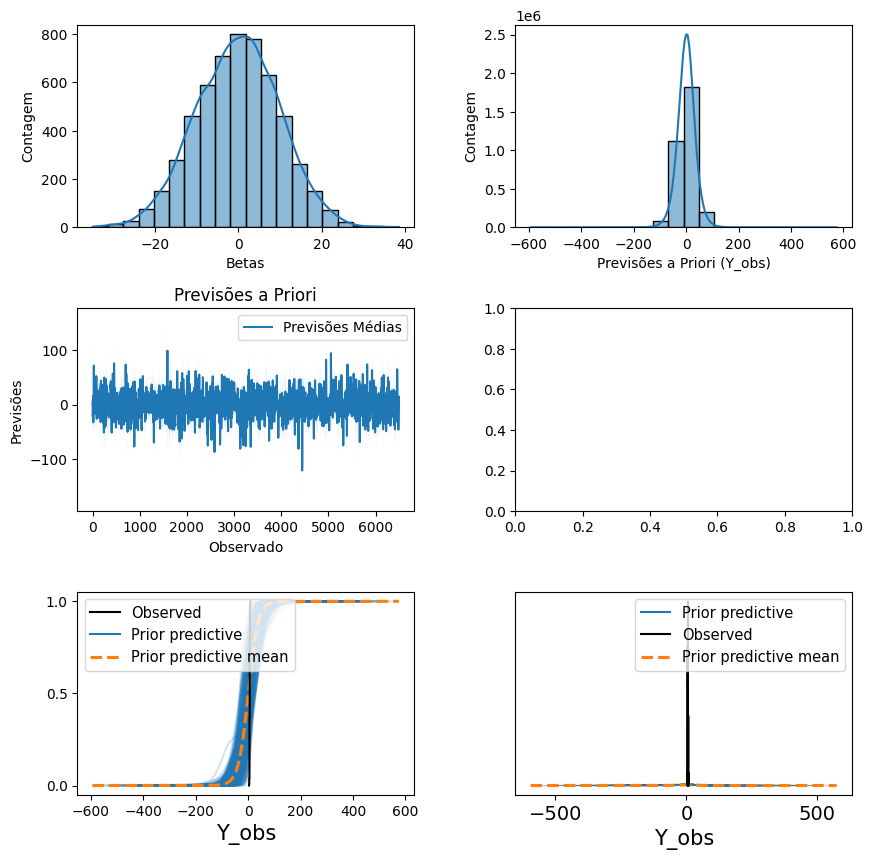

In [13]:
analise_priori(ridge_trace_prior, y)


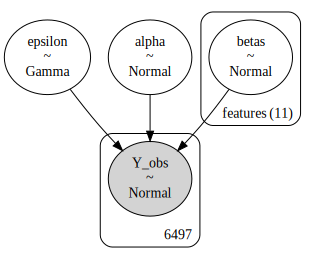

In [14]:
pm.model_to_graphviz(model_ridge)

In [15]:
def analise_posteriori(trace):
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  az.plot_ppc(trace, group='posterior', kind='cumulative', ax=axes[0]);
  az.plot_ppc(trace, group='posterior',ax=axes[1]);

  return fig, axes

Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


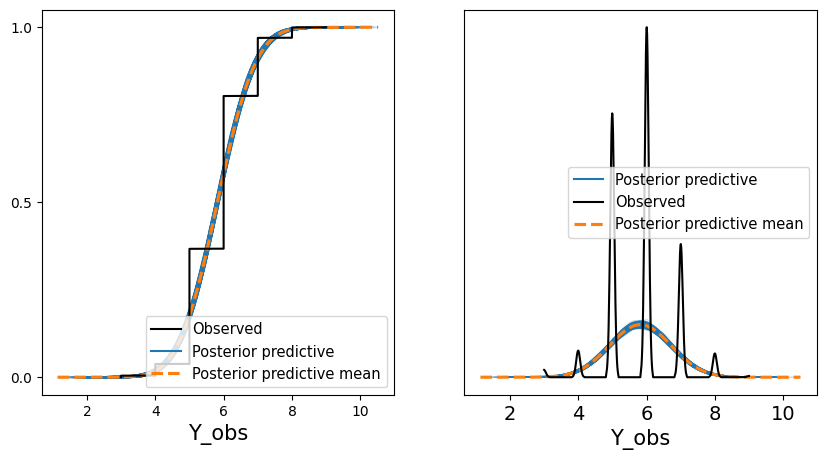

In [16]:

with model_ridge:
  trace_pos_ridge = pm.sample_posterior_predictive(trace_ridge)

analise_posteriori(trace_pos_ridge)


LASSO

In [17]:
import pymc as pm
import pytensor.tensor as pt  # Usar pytensor para a multiplicação de matrizes
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from math import sqrt

In [18]:
# Criar o modelo Lasso Bayesiano
with pm.Model(coords=coords) as model_lasso:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori para os coeficientes de regressão (betas) com distribuição Laplace
    betas = pm.Laplace('betas', mu=0, b=1/sqrt(2), dims='features')  # b é o parâmetro de escala da Laplace

    # Priori para o desvio padrão do erro (epsilon)
    epsilon = pm.Gamma('epsilon', alpha=2, beta=1)

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_scaled, betas)

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori
    lasso_trace_prior = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_lasso = pm.sample(1000, tune=1000, target_accept=0.95)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_lasso)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.819,0.009,5.801,5.835,0.000,0.000,1964.0,1309.0,1.0
betas[0],0.087,0.019,0.053,0.125,0.001,0.000,981.0,1124.0,1.0
betas[1],-0.218,0.013,-0.242,-0.194,0.000,0.000,1571.0,1390.0,1.0
betas[2],-0.016,0.012,-0.039,0.007,0.000,0.000,1813.0,1533.0,1.0
betas[3],0.206,0.024,0.162,0.251,0.001,0.001,1038.0,1270.0,1.0
betas[4],-0.017,0.012,-0.038,0.005,0.000,0.000,1753.0,1288.0,1.0
betas[5],0.105,0.013,0.081,0.130,0.000,0.000,1794.0,1507.0,1.0
betas[6],-0.139,0.015,-0.167,-0.110,0.000,0.000,1962.0,1530.0,1.0
betas[7],-0.163,0.035,-0.230,-0.098,0.001,0.001,928.0,1103.0,1.0
betas[8],0.070,0.014,0.046,0.098,0.000,0.000,1208.0,1584.0,1.0


<ipython-input-6-4581fe9e5373>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Previsões a Priori (Y_obs)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


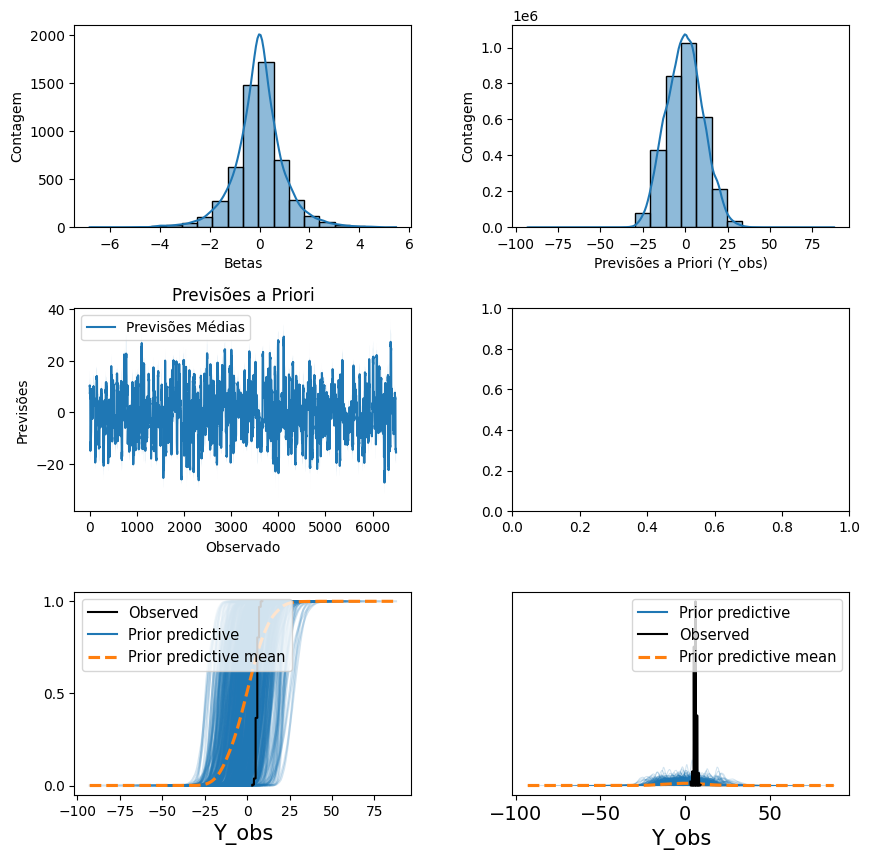

In [19]:
# Supondo que 'y' é seu vetor de dados observados
analise_priori(lasso_trace_prior, y)

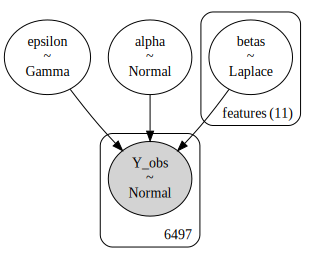

In [20]:

pm.model_to_graphviz(model_lasso)

Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


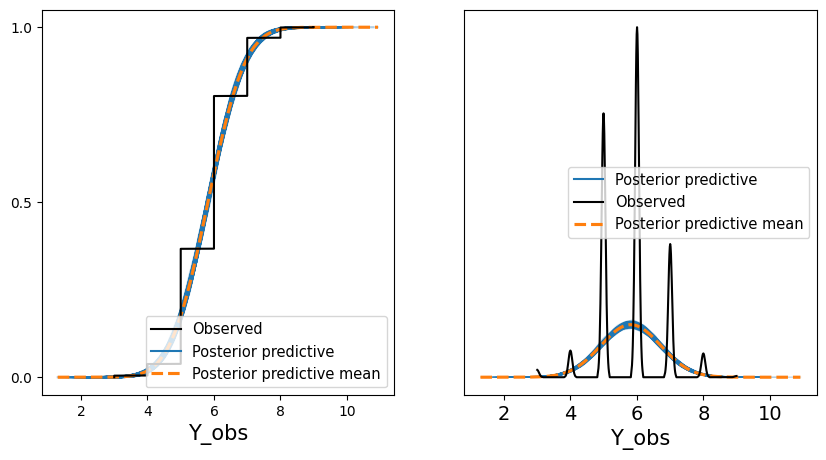

In [21]:
with model_lasso:
  trace_pos_lasso = pm.sample_posterior_predictive(trace_lasso)

analise_posteriori(trace_pos_lasso)

HIERARQUICO

In [22]:
# Criar o modelo Bayesiano Hierárquico
with pm.Model(coords=coords) as model_hierarchical:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori hiperparamétrica para o desvio padrão das Laplaces dos betas
    b_hyper = pm.Gamma('b_hyper', alpha=2, beta=1)

    # Priori hierárquica para os coeficientes de regressão (betas) com distribuição Laplace
    betas = pm.Laplace('betas', mu=0, b=b_hyper, dims='features')

    # Priori hiperparamétrica para o desvio padrão do erro (epsilon)
    epsilon_hyper = pm.Gamma('epsilon_hyper', alpha=2, beta=1)
    epsilon = pm.HalfNormal('epsilon', sigma=epsilon_hyper)

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_scaled, betas)

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori
    trace_prior_hierarchical = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_hierarchical = pm.sample(1000, tune=1000, target_accept=0.95)

    # Calcular log_likelihood
    pm.compute_log_likelihood(trace_hierarchical)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_hierarchical)


Output()

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.818,0.009,5.801,5.836,0.000,0.000,1943.0,1139.0,1.00
b_hyper,0.173,0.064,0.074,0.287,0.002,0.001,1946.0,1204.0,1.00
betas[0],0.078,0.020,0.040,0.117,0.001,0.000,906.0,1124.0,1.01
betas[1],-0.219,0.012,-0.242,-0.196,0.000,0.000,1495.0,1549.0,1.00
betas[2],-0.014,0.012,-0.036,0.008,0.000,0.000,1550.0,1369.0,1.00
betas[3],0.196,0.025,0.150,0.242,0.001,0.001,797.0,1150.0,1.01
betas[4],-0.017,0.011,-0.037,0.005,0.000,0.000,1663.0,1270.0,1.00
betas[5],0.104,0.013,0.079,0.130,0.000,0.000,1623.0,1577.0,1.00
betas[6],-0.137,0.016,-0.164,-0.105,0.000,0.000,1422.0,1320.0,1.00
betas[7],-0.148,0.036,-0.220,-0.084,0.001,0.001,738.0,938.0,1.01


<ipython-input-6-4581fe9e5373>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Previsões a Priori (Y_obs)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


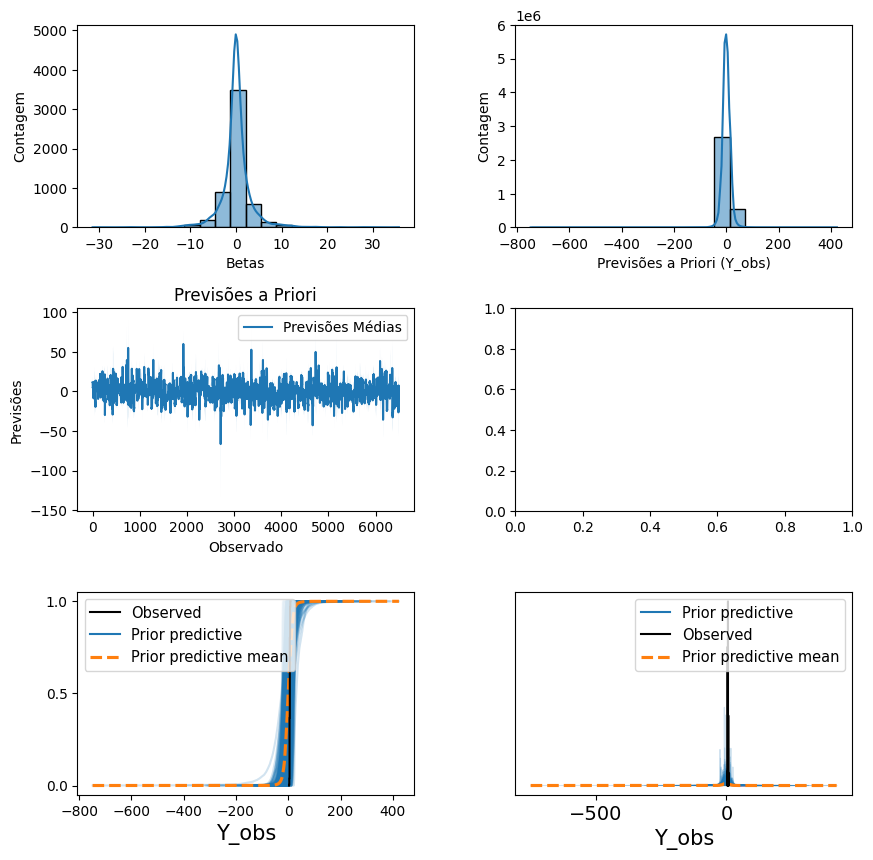

In [23]:

analise_priori(trace_prior_hierarchical,y)

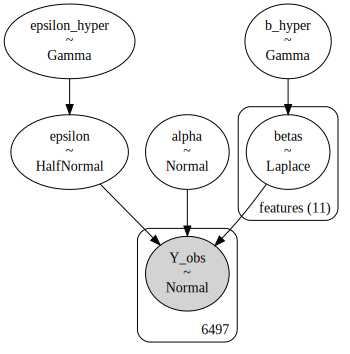

In [24]:
pm.model_to_graphviz(model_hierarchical)

Output()

<Axes: xlabel='Y_obs'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


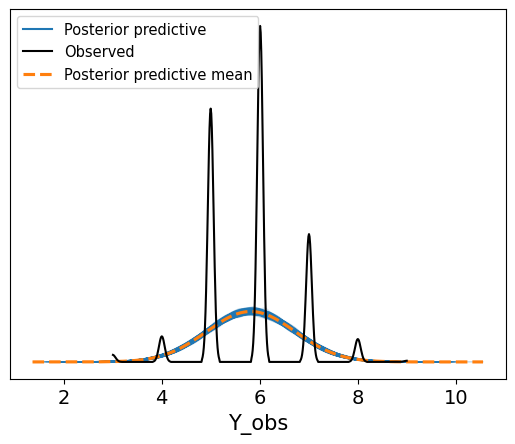

In [25]:
with model_hierarchical:
  trace_pos_hierarc = pm.sample_posterior_predictive(trace_hierarchical)


# Agora, passe o posterior_predictive para a função de análise posterior
az.plot_ppc(posterior_predictive, data_pairs={"Y_obs": "Y_obs"})

ROBUSTO

In [26]:
# Criar o modelo Bayesiano Robusto
with pm.Model(coords=coords) as model_robust:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', 0, 1)

    # Priori para os coeficientes de regressão (betas)
    betas = pm.Normal('betas', 0, 1, dims='features')

    # Priori para os graus de liberdade da distribuição Student-T (df)
    df = pm.Exponential('df', 1)

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_scaled, betas)

    # Definir a verossimilhança com distribuição Student-T
    likelihood = pm.StudentT('Y_obs', nu=df, mu=mu, observed=y)

    # Amostrar da distribuição a priori
    robust_trace_prior = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_robust = pm.sample(1000, tune=1000, target_accept=0.95)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_robust)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.817,0.013,5.792,5.842,0.000,0.000,2031.0,1453.0,1.01
betas[0],0.090,0.028,0.037,0.141,0.001,0.001,882.0,1109.0,1.00
betas[1],-0.217,0.017,-0.248,-0.185,0.000,0.000,1702.0,1311.0,1.00
betas[2],-0.016,0.016,-0.045,0.012,0.000,0.000,1818.0,1394.0,1.00
betas[3],0.207,0.033,0.140,0.264,0.001,0.001,783.0,1079.0,1.00
betas[4],-0.017,0.016,-0.045,0.013,0.000,0.000,1937.0,1434.0,1.00
betas[5],0.110,0.019,0.076,0.146,0.000,0.000,1855.0,1703.0,1.00
betas[6],-0.142,0.021,-0.181,-0.104,0.001,0.000,1716.0,1549.0,1.00
betas[7],-0.167,0.049,-0.260,-0.079,0.002,0.001,769.0,1019.0,1.00
betas[8],0.071,0.020,0.033,0.109,0.001,0.000,976.0,965.0,1.00


<Axes: ylabel='Count'>

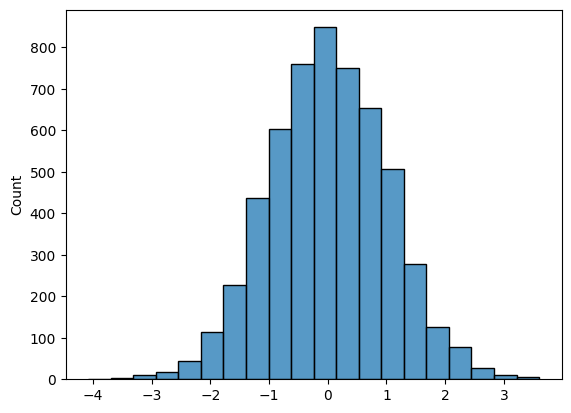

In [28]:
sns.histplot(robust_trace_prior.prior['betas'].values.flatten(), bins=20)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:250: RuntimeWarning: divide by zero encountered in scalar power
  out = t - (2 * N * np.pi**0.5 * f) ** (-0.4)
<ipython-input-29-be4523a56207>:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


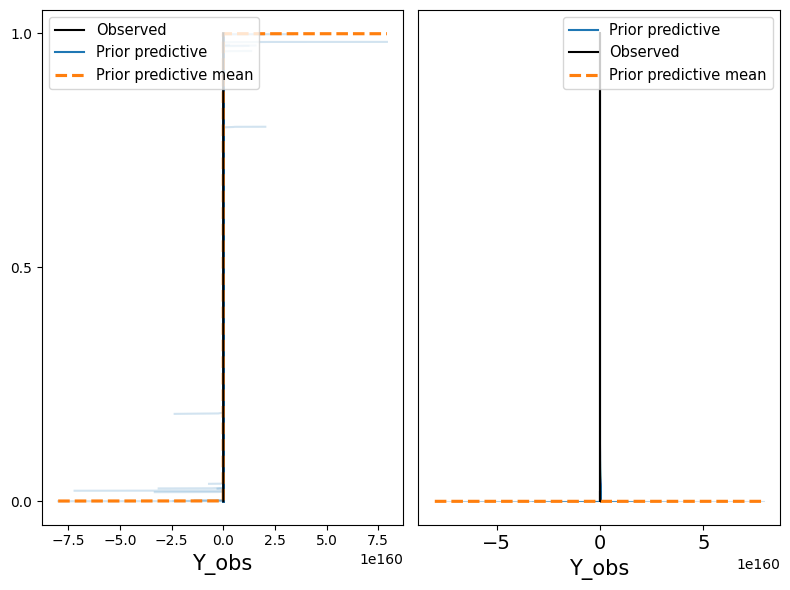

In [29]:
# Criar subplots para exibir os gráficos
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# Plotar o Posterior Predictive Check cumulativo e regular
az.plot_ppc(robust_trace_prior, group='prior', kind='cumulative', ax=axes[0], observed=True)
az.plot_ppc(robust_trace_prior, group='prior', ax=axes[1], observed=True)

# Ajustar layout
plt.tight_layout()
plt.show()

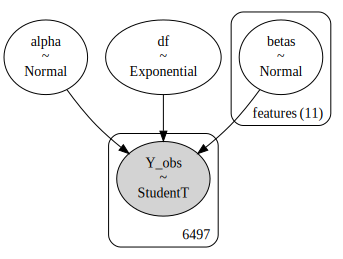

In [30]:
pm.model_to_graphviz(model_robust)

Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


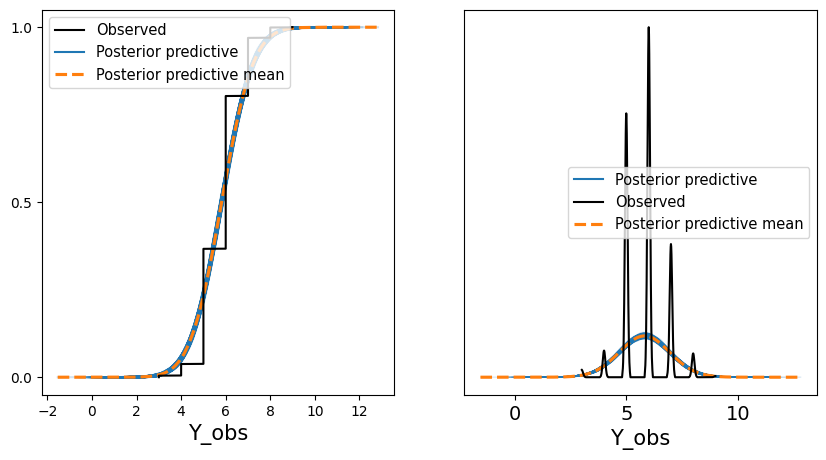

In [31]:
with model_robust:
  trace_pos_robust = pm.sample_posterior_predictive(trace_robust)

analise_posteriori(trace_pos_robust)

COMPARANDO MODELOS

In [37]:
# Verificar se o log_likelihood já existe antes de recalcular
if 'log_likelihood' not in trace_ridge.groups():
    with model_ridge:
        pm.compute_log_likelihood(trace_ridge)


if 'log_likelihood' not in trace_lasso.groups():
    with model_lasso:
        pm.compute_log_likelihood(trace_lasso)

if 'log_likelihood' not in trace_hierarchical.groups():
    with model_hierarchical:
        pm.compute_log_likelihood(trace_robust)

if 'log_likelihood' not in trace_robust.groups():
    with model_robust:
        pm.compute_log_likelihood(trace_robust)

In [32]:
# Verifique se o log_likelihood foi corretamente adicionado
print(trace_ridge.groups())

print(trace_lasso.groups())

print(trace_robust.groups())

print(trace_hierarchical.groups())

['posterior', 'sample_stats', 'observed_data']
['posterior', 'sample_stats', 'observed_data']
['posterior', 'sample_stats', 'observed_data']
['posterior', 'log_likelihood', 'sample_stats', 'observed_data']


In [ ]:
# # Amostragem para o modelo Lasso
# with model_lasso:
#     trace_lasso = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)
#     # Incluindo o cálculo do log likelihood
#     trace_lasso = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

# # Amostragem para o modelo Hierárquico
# with model_hierarchical:
#     trace_hierarchical = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

# # Amostragem para o modelo Robusto
# with model_robust:
#     trace_robust = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

# # Amostragem para o modelo Ridge
# with model_ridge:
#     trace_ridge = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)


In [33]:
import arviz as az
import matplotlib.pyplot as plt

In [34]:


# Verificar se o log_likelihood já existe antes de recalcular
if 'log_likelihood' not in trace_ridge.groups():
    with model_ridge:
        pm.compute_log_likelihood(trace_ridge)


if 'log_likelihood' not in trace_lasso.groups():
    with model_lasso:
        pm.compute_log_likelihood(trace_lasso)

if 'log_likelihood' not in trace_robust.groups():
    with model_robust:
        pm.compute_log_likelihood(trace_robust)

if 'log_likelihood' not in trace_hierarchical.groups():
    with model_hierarchical:
        pm.compute_log_likelihood(trace_hierarchical)


Output()

Output()

Output()

In [35]:



# Verifique se o log_likelihood foi corretamente adicionado
print(trace_ridge.groups())

print(trace_lasso.groups())

print(trace_robust.groups())

print(trace_hierarchical.groups())


['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
['posterior', 'log_likelihood', 'sample_stats', 'observed_data']


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the

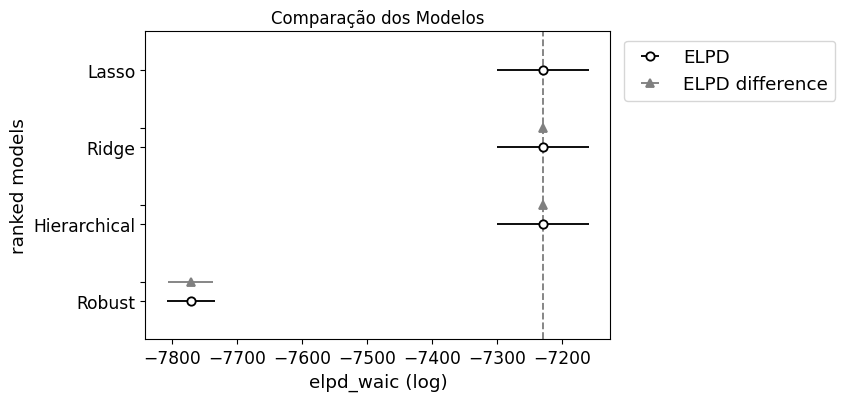

In [36]:
# Comparar os modelos usando o critério WAIC (ou LOO, se preferir)
comparison = az.compare({
    "Ridge": trace_ridge,
    "Lasso": trace_lasso,
    "Hierarchical": trace_hierarchical,
    "Robust": trace_robust
}, ic="waic")  # Você pode usar "loo" no lugar de "waic" se preferir

# Plotar a comparação
az.plot_compare(comparison)
plt.title("Comparação dos Modelos")
plt.show()
